# Imports

In [2]:
import sys
sys.path.append("../../sem")
import sem
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
sns.set_style("white")

# Define SEM Campaign

In [3]:
# Create new SEM campaign with the required path & directory.
campaign_dir = "../lte-results-hyst-ttt"
campaign = sem.CampaignManager.load(campaign_dir, check_repo=False)

# Run the Simulation

In [4]:
# Run the missing simulations with the parameters.
params = {'hysteresis': [x * 0.5 for x in range(0, 30)], 'timeToTrigger': list([0.0, 40.0, 64.0, 80.0, 100.0, 128.0, 160.0, 256.0, 320.0, 480.0, 512.0, 640.0, 1024.0, 1280.0, 2560.0, 5120.0]), 'speed': 20, 'simTime': [5], 'useUdp': [1], 'RngRun': [1]}
#campaign.run_missing_simulations(params, stop_on_errors=False)

# Parse the Results

In [5]:
# Function to get average throughput, number of HOs and RLFs
def get_average_throughput(result):    
    if result['output']['stderr'] != "":
        throughput = -1
        num_HOs = -1
        num_RLFs = -1
    else:
        split_results = result['output']['stdout'].split("\n")
        throughput = float(split_results[-1].split(" ")[1])
        num_HOs = 0
        num_RLFs = 0
        for line in split_results:
            event = line.split(":")[0]
            if event == "UE_HO_START":
                num_HOs += 1
            elif event == "UE_RLF_DETECTED":
                num_RLFs += 1	
    return [num_HOs, num_RLFs, throughput]

In [6]:
# Use the parsing function to create a Pandas dataframe
results = campaign.get_results_as_dataframe(get_average_throughput, ['Num_HOs', 'Num_RLFs', 'Throughput'], params=params, drop_constant_columns=True)
print(results)

     hysteresis  timeToTrigger  Num_HOs  Num_RLFs  Throughput
0           0.0            0.0       12         0  13678000.0
1           0.0           40.0       12         0  13497100.0
2           0.0           64.0       12         0  13397200.0
3           0.0           80.0       12         0  13553000.0
4           0.0          100.0       12         0  13520300.0
..          ...            ...      ...       ...         ...
475        14.5          640.0        1         3  12366400.0
476        14.5         1024.0        0         3  12332900.0
477        14.5         1280.0        0         3  12332900.0
478        14.5         2560.0        0         3  12332900.0
479        14.5         5120.0        0         3  12332900.0

[480 rows x 5 columns]


Text(0.5, 0.92, 'Throughput Plot for Hyst-TTT')

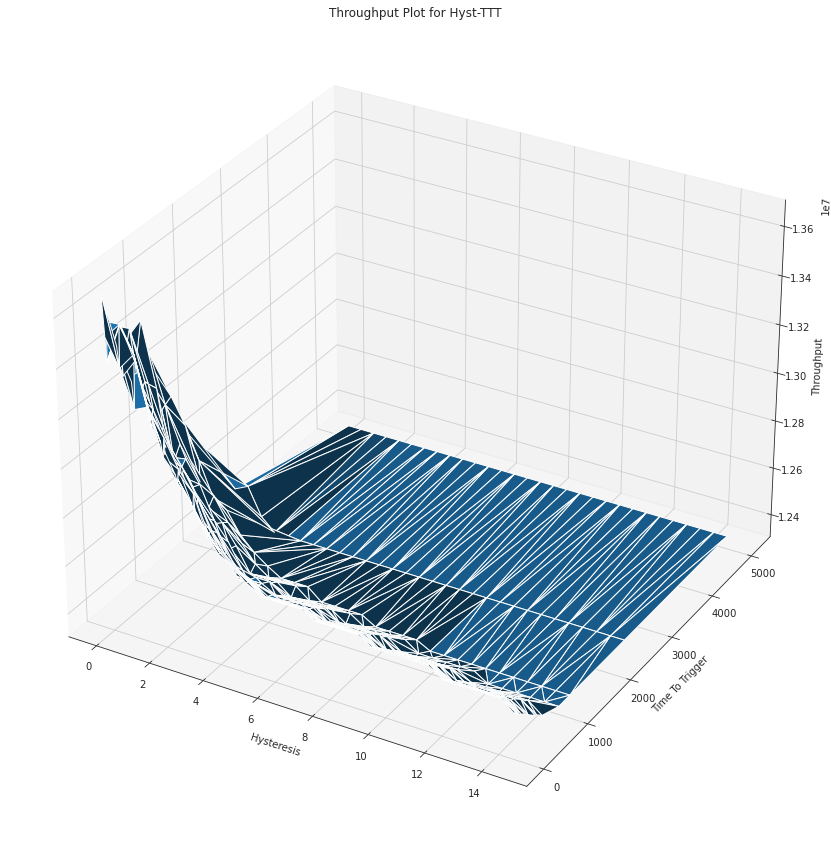

In [6]:
fig = plt.figure(figsize=(25, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results['hysteresis'], results['timeToTrigger'], results['Throughput'])
ax.set_xlabel('Hysteresis')
ax.set_ylabel('Time To Trigger')
ax.set_zlabel('Throughput')
ax.set_title('Throughput Plot for Hyst-TTT')

Text(0.5, 0.92, 'Num_HOs Plot for Hyst-TTT')

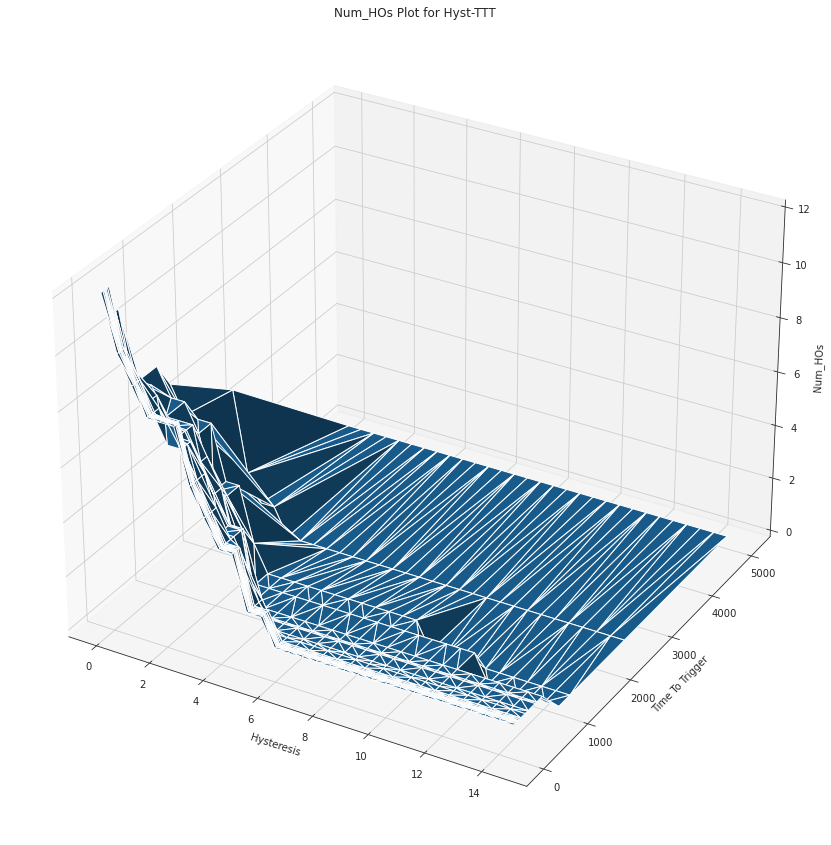

In [7]:
fig = plt.figure(figsize=(25, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results['hysteresis'], results['timeToTrigger'], results['Num_HOs'])
ax.set_xlabel('Hysteresis')
ax.set_ylabel('Time To Trigger')
ax.set_zlabel('Num_HOs')
ax.set_title('Num_HOs Plot for Hyst-TTT')

Text(0.5, 0.92, 'Num_RLFs Plot for Hyst-TTT')

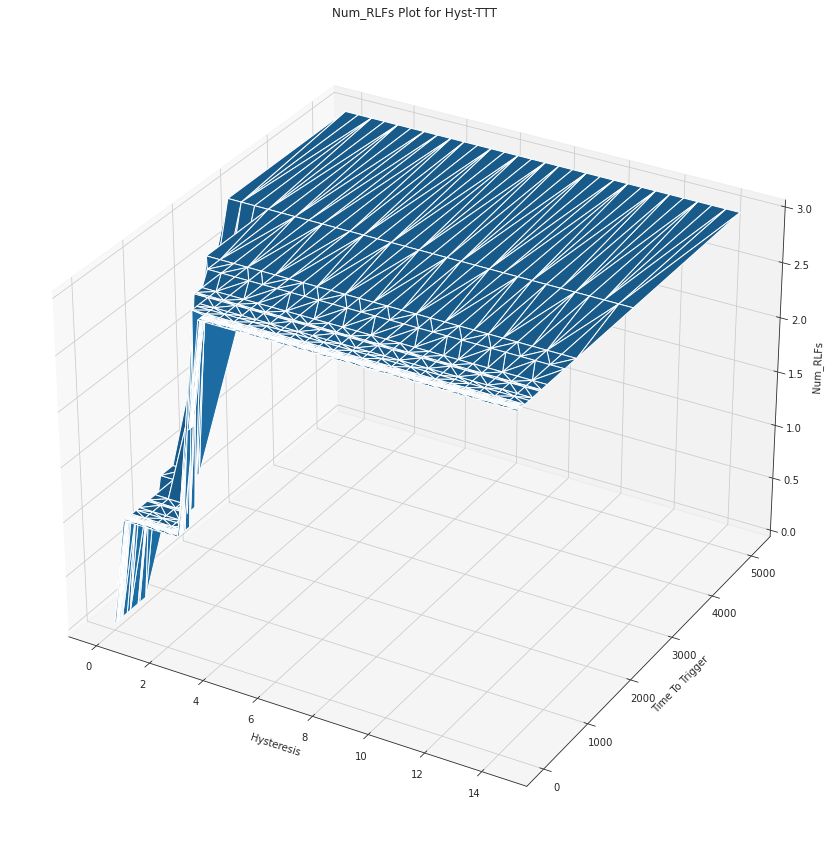

In [7]:
fig = plt.figure(figsize=(25, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results['hysteresis'], results['timeToTrigger'], results['Num_RLFs'])
ax.set_xlabel('Hysteresis')
ax.set_ylabel('Time To Trigger')
ax.set_zlabel('Num_RLFs')
ax.set_title('Num_RLFs Plot for Hyst-TTT')

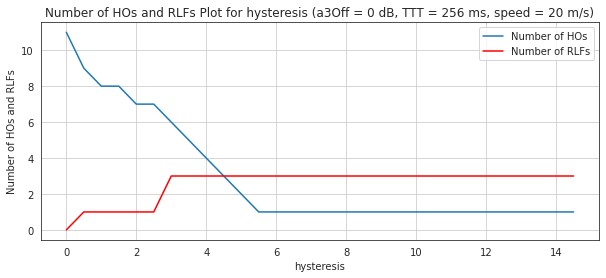

In [8]:
results2 = results[(results['timeToTrigger'] == 256)]
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(results2['hysteresis'], results2['Num_HOs'])
ax.plot(results2['hysteresis'], results2['Num_RLFs'], color = 'red')
ax.grid()
ax.set_xlabel('hysteresis')
ax.set_ylabel('Number of HOs and RLFs')
ax.set_title('Number of HOs and RLFs Plot for hysteresis (a3Off = 0 dB, TTT = 256 ms, speed = 20 m/s)')
ax.legend(['Number of HOs', 'Number of RLFs'])

In [9]:
from sklearn.cross_decomposition import PLSRegression
regr = PLSRegression(n_components=2)
regr.fit(results['Num_HOs'].to_numpy().reshape(-1, 1), results['Num_RLFs'].to_numpy().reshape(-1, 1))
pred = regr.predict(results['Num_HOs'].to_numpy().reshape(-1, 1))

/home/sachin/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:185: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


Text(0.5, 1.0, 'Inverse Relation Between number of HOs and RLFs')

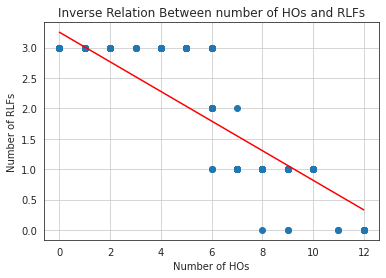

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.scatter(results['Num_HOs'], results['Num_RLFs'])
ax.plot(results['Num_HOs'], pred, color = 'red')
ax.grid()
ax.set_xlabel('Number of HOs')
ax.set_ylabel('Number of RLFs')
ax.set_title('Inverse Relation Between number of HOs and RLFs')